# Efficient Gaussian Random Field Inference on Graphs - Regression Task on Traffic Dataset

This notebook contains the following:

1. Showing the baseline performance using the exact diffusion kernel.
2. Showing the similar level performance using Product of Feature Matrices (PoFM) kernel, compared across the parameter 'max_expansion' which determines the order of the approximation.
3. Showing the convergence of the GRF to the PoFM kernel for 'max_expansion = 5'
4. (Opt) Showing the performance of grf kernel with arbitrary modulation function. 

## Setup

In [2]:
import tensorflow as tf
import numpy as np
import scipy.special
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
from tqdm import tqdm

import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

from efficient_graph_gp.graph_kernels import get_normalized_laplacian
from efficient_graph_gp.gpflow_kernels import GraphDiffusionFastGRFKernel, GraphDiffusionPoFMKernel, GraphDiffusionKernel, GraphGeneralPoFMKernel, GraphGeneralFastGRFKernel
from utils import compute_fro
from traffic_utils.preprocessing import load_PEMS
from traffic_utils.plotting import plot_PEMS

In [3]:
# Load and preprocess the PEMS dataset

np.random.seed(1111)
num_eigenpairs = 500
dataset = 'PeMS-Bay-new'
num_train = 250

G, data_train, data_test, data = load_PEMS(num_train=num_train)
x_train, y_train = data_train
x_test, y_test = data_test
x, y = data
orig_mean, orig_std = np.mean(y_train), np.std(y_train)
y_train = (y_train-orig_mean)/orig_std
y_test = (y_test-orig_mean)/orig_std

X_train = tf.convert_to_tensor(x_train)
X_full = tf.convert_to_tensor(x)
Y_train = tf.convert_to_tensor(y_train)

adjacency_matrix = nx.to_numpy_array(G)  # Converts to NumPy adjacency matrix
print(adjacency_matrix.shape)  # Check matrix size

/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/experiments/traffic_dataset/traffic_utils/preprocessing.py:90: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  G = pickle.load(f)


epsg:4326
(1016, 1016)


/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/venv/lib/python3.11/site-packages/osmnx/convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])


In [4]:
def gp_training(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    
    # # Explicitly set dtype to float32
    # dtype = tf.float64
    # # Assign Uniform prior with explicitly cast float32 values
    # model.kernel.beta.prior = tfp.distributions.Uniform(
    #     low=tf.constant(0.0, dtype=dtype), 
    #     high=tf.constant(2.0, dtype=dtype)
    # )
    
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

def configure_model(model, hyperparameters):
    model.kernel.beta.assign(hyperparameters['beta'])
    model.kernel.sigma_f.assign(hyperparameters['sigma_f'])
    model.likelihood.variance.assign(hyperparameters['variance'])
    return model

def configure_model_general(model, hyperparameters):
    model.kernel.modulator_vector.assign(hyperparameters['modulator_vector'])
    model.likelihood.variance.assign(hyperparameters['variance'])
    return model

def gp_inference(model, X_new):
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return mean, stddev

def evaluate(model, x_test, y_test, quiet=False):
    
    train_likelihood = model.log_marginal_likelihood().numpy()
    
    mean, cov = model.predict_f(x_test, full_cov=True)
    l2_error = orig_std * np.linalg.norm(y_test.ravel() - mean.numpy().ravel()) / len(y_test.ravel())
    
    mean, cov = tf.reshape(mean, [-1]), cov[0]
    cov = cov + tf.linalg.diag(tf.fill([len(y_test)], model.likelihood.variance))
    dist = tfp.distributions.MultivariateNormalTriL(mean, cov)
    test_likelihood = dist.log_prob(tf.reshape(y_test, [-1])).numpy()
    
    if not quiet:
        print(f"Train likelihood: {train_likelihood}")
        print(f"L2 error: {l2_error}")
        print(f"Test likelihood: {test_likelihood}")
    
    return train_likelihood, l2_error, test_likelihood

## 0. Learn a good set of hyper-parameters with the PoFM Kernel

We use the PoFM kernel to learn a set of hyper-param with physical sense. 

In short, the results confirm a very sparse, low-clustering, weakly connected graph with long weighted distances and slowly growing multi-hop neighborhoods. Any neighborhood-based GNN or Laplacian-based model will need to account for these structural properties—likely by choosing enough hops to capture relevant context without excessive computational overhead.

We use a neighbourhood size of 5-hop to avoid **oversmoothing**.

/var/folders/0v/vn4885796ql7_mlpq_dc1n9r0000gn/T/ipykernel_1857/3633228529.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


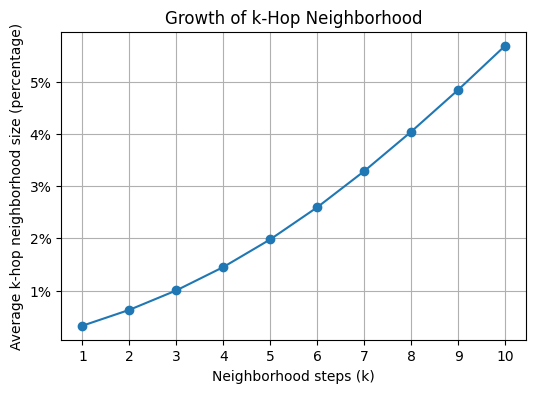

In [6]:
# ------------------------------------------
# 2. Create a NetworkX Graph from the Matrix
# ------------------------------------------
# This builds an undirected weighted graph.
G = nx.from_numpy_array(adjacency_matrix)

# -----------------------------------------------------------
# 7. Explore k-Step Neighborhood Aggregation (Ego Networks)
# -----------------------------------------------------------
# This helps understand how many nodes are reached as we aggregate neighbors.
def neighborhood_size(G, node, k):
    """
    Returns the set of nodes within k steps from the given node.
    """
    # nx.ego_graph returns the subgraph induced by nodes within radius=k.
    return nx.ego_graph(G, node, radius=k).nodes()

max_k = 10  # Feel free to extend this range based on your needs.
avg_neighborhood = {}
graph_size = len(G.nodes())


for k in range(1, max_k + 1):
    sizes = []
    for node in G.nodes():
        sizes.append(len(list(neighborhood_size(G, node, k))))
    avg_neighborhood[k] = np.mean(sizes) / graph_size

# Plot the growth of the k-hop neighborhood.
plt.figure(figsize=(6, 4))
plt.plot(list(avg_neighborhood.keys()), list(avg_neighborhood.values()), marker='o')
plt.xlabel("Neighborhood steps (k)")
plt.ylabel("Average k-hop neighborhood size (percentage)")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.title("Growth of k-Hop Neighborhood")
plt.xticks(range(1, max_k+1))
plt.grid(True)
plt.show()


In [7]:
MAX_WALK_LENGTH = 3

## 1. Performance of PoFM Kernel

In [8]:
# The normalized laplacian is used
graph_kernel = GraphDiffusionPoFMKernel(adjacency_matrix,
                                        max_expansion=MAX_WALK_LENGTH,
                                        normalize_laplacian=True)

model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.18522  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.45713  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.203835 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

In [9]:
pofm_train_likelihood, pofm_l2_error, pofm_test_likelihood = evaluate(model, x_test, y_test)

Train likelihood: -342.5482822527562
L2 error: 1.615528040394973
Test likelihood: -101.77886913401339


In [10]:
learned_hyperparameters = {
    "beta": model.kernel.beta.numpy(),
    "sigma_f": model.kernel.sigma_f.numpy(),
    "variance": model.likelihood.variance.numpy()
}

## 2. Performance of the Exact Diffusion Kernel

In [21]:
graph_kernel = GraphDiffusionKernel(adjacency_matrix, normalize_laplacian=True)
model = gpflow.models.GPR(data=(X_train, Y_train), kernel=graph_kernel, mean_function=None, noise_variance=0.01)
model = configure_model(model, learned_hyperparameters)
mean, stddev = gp_inference(model, X_full)

In [22]:
diffusion_train_likelihood, diffusion_l2_error, diffusion_test_likelihood = evaluate(model, x_test, y_test)

Train likelihood: -349.08321650504143
L2 error: 1.6622468658334817
Test likelihood: -100.68403323897631


## 1* Learn the Hyperparameters Directly with GRF

### Again, the Fro Norm

In [11]:
# Define the range of walk lengths
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
grf_gram_matrices = []


# This beta value is previosuly learned from the PoFM kernel
beta_test = learned_hyperparameters['beta']

pofm_kernel = GraphDiffusionPoFMKernel(adjacency_matrix,
                                       max_expansion=MAX_WALK_LENGTH,
                                       normalize_laplacian=True)

gram_pofm = pofm_kernel.compute_diffusion_kernel(adjacency_matrix, beta_test, MAX_WALK_LENGTH) # note sigma_f = 1 is used here

for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                               walks_per_node=walks_per_node,
                                               p_halt=0.1,
                                               max_walk_length=5+1,
                                               normalize_laplacian=True)
    # Learn the hyperparameters directly with GRF
    model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
    grf_learned_beta = model.kernel.beta.numpy()
    grf_gram_matrices.append(graph_kernel.grf_kernel(beta=grf_learned_beta, sigma_f=1))

Walk lengths: 100%|██████████| 14/14 [18:06<00:00, 77.62s/it] 


In [12]:
grf_learned_beta

array(2.8543131)

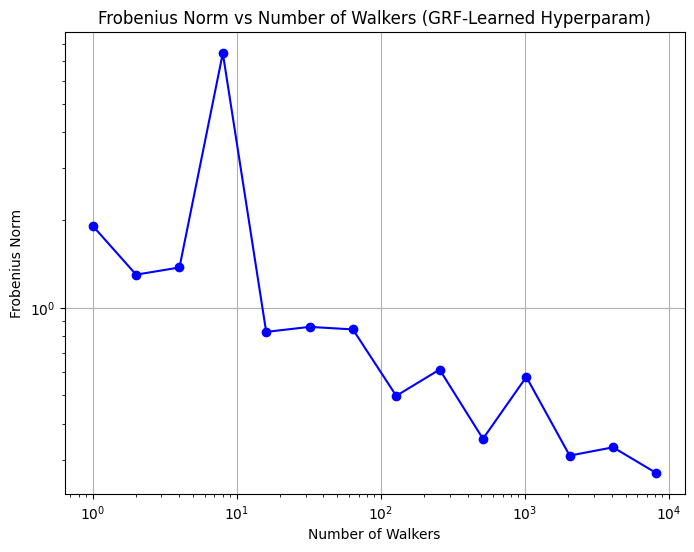

In [15]:
# Calculate Frobenius norms
frobenius_norms = [compute_fro(gram_pofm, grf_gram) for grf_gram in grf_gram_matrices]

# Plot Frobenius norm vs. Number of Walkers
plt.figure(figsize=(8, 6))
plt.plot(walks_per_nodes, frobenius_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('Frobenius Norm')
plt.yscale('log')
plt.title('Frobenius Norm vs Number of Walkers (GRF-Learned Hyperparam)')
plt.grid(True)
plt.show()

### And the L2 Error for Prediction - We Expect Better Performance Than Simply Comparing Fro Norm

In [ ]:
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384]
grf_metrics = []


for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                               walks_per_node=walks_per_node,
                                               p_halt=0.1,
                                               max_walk_length=MAX_WALK_LENGTH+1,
                                               beta = learned_hyperparameters['beta'],
                                               normalize_laplacian=True)
    
    # model = gpflow.models.GPR(data=(X_train, Y_train), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    # model = configure_model(model, learned_hyperparameters)
    # mean, stddev = gp_inference(model, X_full)
    model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
    train_likelihood, l2_error, test_likelihood = evaluate(model, x_test, y_test, quiet=True)
    results = {'walks_per_node': walks_per_node,
                'train_likelihood': train_likelihood,
                'l2_error': l2_error,
                'test_likelihood': test_likelihood}
    grf_metrics.append(results)


Walk lengths: 100%|██████████| 14/14 [08:02<00:00, 34.48s/it] 


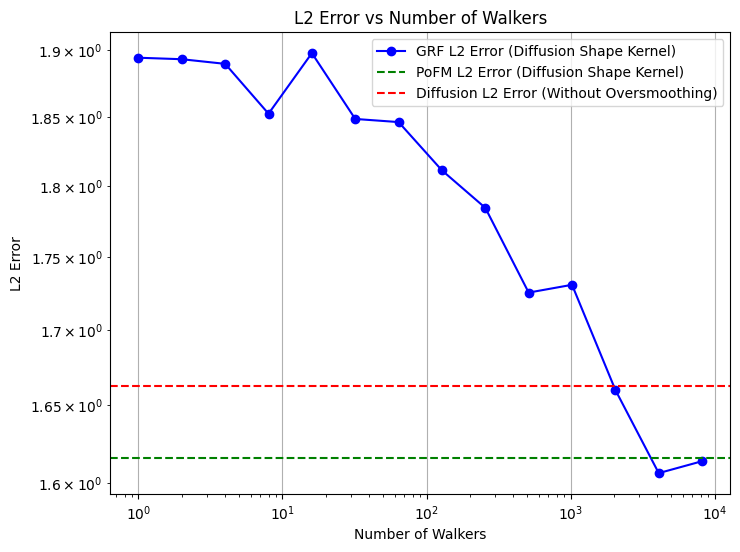

In [25]:
# Extract the number of walkers and corresponding L2 errors from grf_metrics
walkers = [metric['walks_per_node'] for metric in grf_metrics]
l2_errors = [metric['l2_error'] for metric in grf_metrics]

# Plot the L2 error vs. number of walkers
plt.figure(figsize=(8, 6))
plt.plot(walkers, l2_errors, marker='o', linestyle='-', color='b', label='GRF L2 Error (Diffusion Shape Kernel)')
plt.axhline(y=pofm_l2_error, color='g', linestyle='--', label='PoFM L2 Error (Diffusion Shape Kernel)')
plt.axhline(y=diffusion_l2_error, color='r', linestyle='--', label='Diffusion L2 Error (Without Oversmoothing)')
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('L2 Error')
plt.yscale('log')
plt.title('L2 Error vs Number of Walkers')
plt.legend()
plt.grid(True)
plt.show()

## 3. Performance of the GRF Approximated Diffusion Kernel

Takes roughly 20 mins to run

### 3.1 Track the Convergence of the Gram Matrix

In [130]:
# Define the range of walk lengths
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
grf_gram_matrices = []

beta_test = learned_hyperparameters['beta']
# beta_test = 0.1

pofm_kernel = GraphDiffusionPoFMKernel(adjacency_matrix,
                                       max_expansion=MAX_WALK_LENGTH,
                                       normalize_laplacian=True)

gram_pofm = pofm_kernel.compute_diffusion_kernel(adjacency_matrix, beta_test, MAX_WALK_LENGTH) # note sigma_f = 1 is used here

for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                               walks_per_node=walks_per_node,
                                               p_halt=0.1,
                                               max_walk_length=5+1,
                                               normalize_laplacian=True)
    grf_gram_matrices.append(graph_kernel.grf_kernel(beta=beta_test, sigma_f=1))

Walk lengths: 100%|██████████| 14/14 [10:21<00:00, 44.42s/it] 


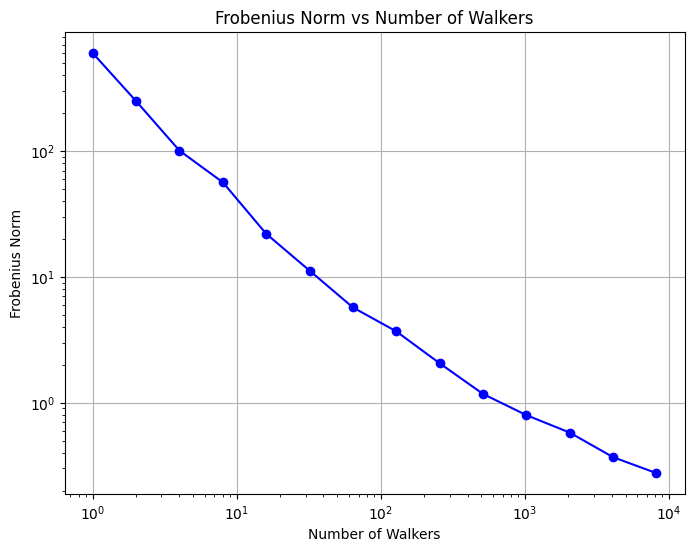

In [133]:
# Calculate Frobenius norms
frobenius_norms = [compute_fro(gram_pofm, grf_gram) for grf_gram in grf_gram_matrices]

# Plot Frobenius norm vs. Number of Walkers
plt.figure(figsize=(8, 6))
plt.plot(walks_per_nodes, frobenius_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('Frobenius Norm')
plt.yscale('log')
plt.title('Frobenius Norm vs Number of Walkers')
plt.grid(True)
plt.show()

### 3.2 Track the Convergence of L2 Error

In [134]:
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
grf_metrics = []


for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                               walks_per_node=walks_per_node,
                                               p_halt=0.1,
                                               max_walk_length=MAX_WALK_LENGTH+1,
                                               beta = learned_hyperparameters['beta'],
                                               normalize_laplacian=True)
    
    model = gpflow.models.GPR(data=(X_train, Y_train), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    model = configure_model(model, learned_hyperparameters)
    mean, stddev = gp_inference(model, X_full)
    train_likelihood, l2_error, test_likelihood = evaluate(model, x_test, y_test, quiet=True)
    results = {'walks_per_node': walks_per_node,
                'train_likelihood': train_likelihood,
                'l2_error': l2_error,
                'test_likelihood': test_likelihood}
    grf_metrics.append(results)


Walk lengths: 100%|██████████| 14/14 [10:19<00:00, 44.26s/it] 


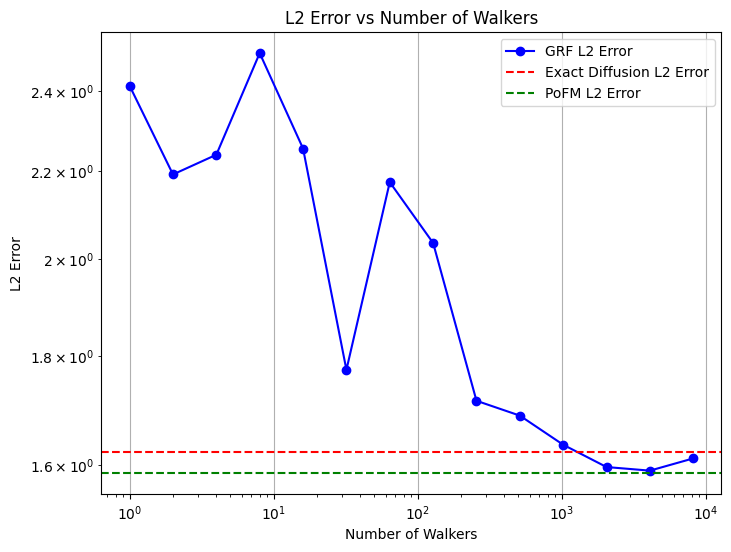

In [137]:
# Extract the number of walkers and corresponding L2 errors from grf_metrics
walkers = [metric['walks_per_node'] for metric in grf_metrics]
l2_errors = [metric['l2_error'] for metric in grf_metrics]

# Plot the L2 error vs. number of walkers
plt.figure(figsize=(8, 6))
plt.plot(walkers, l2_errors, marker='o', linestyle='-', color='b', label='GRF L2 Error')
plt.axhline(y=diffusion_l2_error, color='r', linestyle='--', label='Exact Diffusion L2 Error')
plt.axhline(y=pofm_l2_error, color='g', linestyle='--', label='PoFM L2 Error')
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('L2 Error')
plt.yscale('log')
plt.title('L2 Error vs Number of Walkers')
plt.legend()
plt.grid(True)
plt.show()

## 4. Performance of the GRF-based non-Diffusion Kernel (with Arbitrary Modulation Function)

We can learn a broader family of graph kernel with arbitrary modulation function, in our example we got better l2 error.

### 4.1 First Learn the Hyperparamters for Arbitrary Modulation Functions

In [9]:
# The normalized laplacian is used
graph_kernel = GraphGeneralPoFMKernel(adjacency_matrix,
                                      max_walk_length=MAX_WALK_LENGTH,
                                      normalize_laplacian=True) # note a random initialization of modulation function is used.

model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

╒═════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════════════════╕
│ name                        │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                            │
╞═════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════════════════╡
│ GPR.kernel.modulator_vector │ Parameter │ Identity         │         │ True        │ (5,)    │ float64 │ [2.06668, -11.94356, 15.14977... │
├─────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────┤
│ GPR.likelihood.variance     │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.10087993747612783              │
╘═════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧══════════════════════════════════╛


In [10]:
g_pofm_train_likelihood, g_pofm_l2_error, g_pofm_test_likelihood = evaluate(model, x_test, y_test)

Train likelihood: -328.11132887411543
L2 error: 1.4681704569907061
Test likelihood: -93.83586540910409


In [21]:
g_learned_hyperparameters = {
    "modulator_vector": model.kernel.modulator_vector.numpy(),
    "variance": model.likelihood.variance.numpy()
}

g_learned_hyperparameters["modulator_vector"]

array([  2.06667647, -11.94356097,  15.14977322,  -6.96142691,
         1.0995026 ])

### 4.2 (Opt) Compare with the actual modulation function learned with diffusion kernel

In [20]:
sample_beta = 2.87312 
sample_sigma_f = 1.51095

def diffusion_modulator_np(length: np.ndarray, beta: float) -> np.ndarray:
    length = length.astype(np.float64)
    beta = np.float64(beta)  # Ensure beta is a float
    two = np.float64(2.0)
    
    # Compute numerator safely
    numerator = np.power(np.abs(beta), length) * (-1) ** length  
    denominator = np.power(two, length) * np.exp(scipy.special.gammaln(length + 1.0))
    
    return numerator / denominator

# Compute the diffusion modulator vector
example_diffusion_modulator_vector = (
    sample_sigma_f**2 * diffusion_modulator_np(
        length=np.arange(MAX_WALK_LENGTH),  # Generate length array
        beta=sample_beta  # Pass scalar beta
    )
)

example_diffusion_modulator_vector

array([ 2.2829699 , -3.27962324,  2.35568778, -1.12802895,  0.40512032])

### 4.3 Performance of the GRF-Approximated Kernel

#### 4.3.1 Gram Matrices

In [45]:
# Define the range of walk lengths
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768]
grf_gram_matrices = []

# beta_test = 0.1

pofm_kernel = GraphGeneralPoFMKernel(adjacency_matrix,
                                      max_walk_length=MAX_WALK_LENGTH,
                                      normalize_laplacian=True) # note a random initialization of modulation function is used.


gram_pofm = pofm_kernel.pofm_kernel(modulator_vector=g_learned_hyperparameters["modulator_vector"])

for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphGeneralFastGRFKernel(adjacency_matrix,
                                             walks_per_node=walks_per_node,
                                             p_halt=0.1,
                                             max_walk_length=MAX_WALK_LENGTH,
                                             modulator_vector=g_learned_hyperparameters["modulator_vector"])
    grf_gram_matrices.append(graph_kernel.grf_kernel(modulator_vector=g_learned_hyperparameters["modulator_vector"]))

Walk lengths: 100%|██████████| 16/16 [35:52<00:00, 134.50s/it]


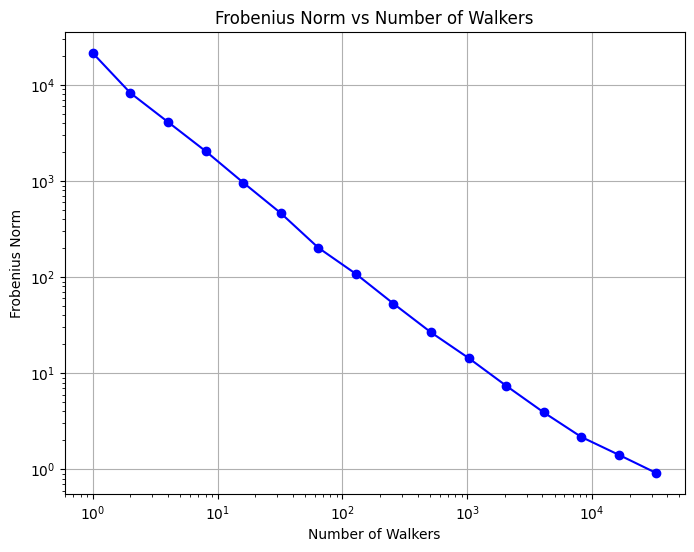

In [46]:
# Calculate Frobenius norms
frobenius_norms = [compute_fro(gram_pofm, grf_gram) for grf_gram in grf_gram_matrices]

# Plot Frobenius norm vs. Number of Walkers
plt.figure(figsize=(8, 6))
plt.plot(walks_per_nodes, frobenius_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('Frobenius Norm')
plt.yscale('log')
plt.title('Frobenius Norm vs Number of Walkers')
plt.grid(True)
plt.show()

In [49]:
gram_pofm

<tf.Tensor: shape=(1016, 1016), dtype=float64, numpy=
array([[ 0.7052194 ,  0.32090096, -0.00687718, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32090096,  0.86154884,  0.29171644, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00687718,  0.29171644,  0.35942236, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.92471684,
         0.22608714,  0.21677849],
       [ 0.        ,  0.        ,  0.        , ...,  0.22608714,
         1.84263305,  1.40908543],
       [ 0.        ,  0.        ,  0.        , ...,  0.21677849,
         1.40908543,  1.875747  ]])>

In [50]:
grf_gram_matrices[-1]

<tf.Tensor: shape=(1016, 1016), dtype=float64, numpy=
array([[0.73720584, 0.15817019, 0.15533619, ..., 0.        , 0.        ,
        0.        ],
       [0.15817019, 0.69618687, 0.32961002, ..., 0.        , 0.        ,
        0.        ],
       [0.15533619, 0.32961002, 0.58071943, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.22832667, 0.15783154,
        0.20647332],
       [0.        , 0.        , 0.        , ..., 0.15783154, 1.52257289,
        1.59874033],
       [0.        , 0.        , 0.        , ..., 0.20647332, 1.59874033,
        4.22840292]])>

#### 4.3.2 L2 Error

In [47]:
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768]
grf_metrics = []


for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphGeneralFastGRFKernel(adjacency_matrix,
                                             walks_per_node=walks_per_node,
                                             p_halt=0.1,
                                             max_walk_length=MAX_WALK_LENGTH,
                                             modulator_vector=g_learned_hyperparameters["modulator_vector"])
    
    model = gpflow.models.GPR(data=(X_train, Y_train), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    model = configure_model_general(model, g_learned_hyperparameters)
    mean, stddev = gp_inference(model, X_full)
    train_likelihood, l2_error, test_likelihood = evaluate(model, x_test, y_test, quiet=True)
    results = {'walks_per_node': walks_per_node,
                'train_likelihood': train_likelihood,
                'l2_error': l2_error,
                'test_likelihood': test_likelihood}
    grf_metrics.append(results)


Walk lengths: 100%|██████████| 16/16 [35:46<00:00, 134.14s/it]


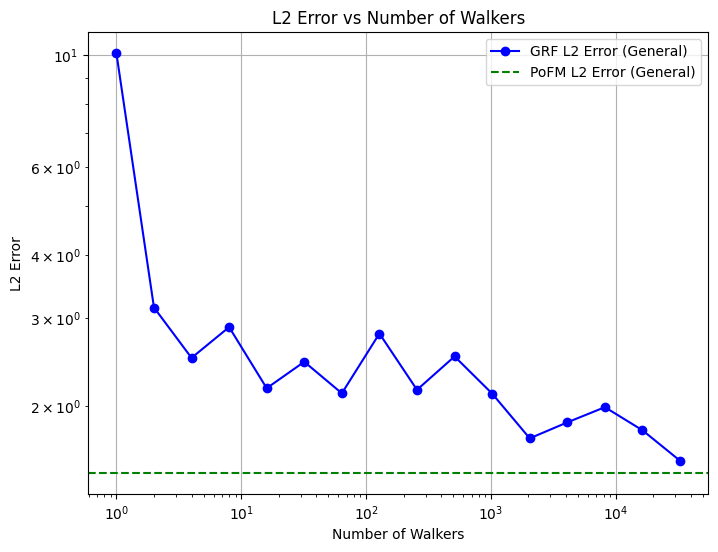

In [48]:
# Extract the number of walkers and corresponding L2 errors from grf_metrics
walkers = [metric['walks_per_node'] for metric in grf_metrics]
l2_errors = [metric['l2_error'] for metric in grf_metrics]

# Plot the L2 error vs. number of walkers
plt.figure(figsize=(8, 6))
plt.plot(walkers, l2_errors, marker='o', linestyle='-', color='b', label='GRF L2 Error (General)')
plt.axhline(y=g_pofm_l2_error, color='g', linestyle='--', label='PoFM L2 Error (General)')
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('L2 Error')
plt.yscale('log')
plt.title('L2 Error vs Number of Walkers')
plt.legend()
plt.grid(True)
plt.show()

## Learn the Hyperparamter with GRF


Using GRF to learn hyperparam:
1. in practice use GRF for everything
2. PoFM: best possible hyperparam with inifinite number of walks
3. we expect GRF to learn smaller beta (designed for smaller number of walks)
4. rethink the samping destribution